In [1]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 5.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 5.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 2.5 MB 5.1 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 750 kB 5.3 MB/s 
     |████████████████████████████████| 407 kB 4.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=26ca56bd30d15d1e62f3cbf6c0109e22508726d31a7b270fead18020d29a0b3a
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [2]:
from torch_geometric.datasets import KarateClub

In [3]:
dataset = KarateClub()
print("Dataset:", dataset)
print("# Graphs:", len(dataset))
print("# Features:", dataset.num_features)
print("# Classes:", dataset.num_classes)

Dataset: KarateClub()
# Graphs: 1
# Features: 34
# Classes: 4


In [4]:
data = dataset[0]
print(data)
print("Training nodes:", data.train_mask.sum().item())
print("Is directed:", data.is_directed())

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Training nodes: 4
Is directed: False


In [5]:
import networkx as nx

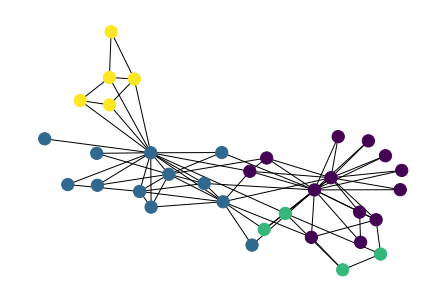

In [6]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
nx.draw(G, node_color=data.y, node_size=150)

# Semi-supervised node classification

In [7]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [8]:
class GCN(torch.nn.Module):
  def __init__(self):
    super(GCN, self).__init__()
    torch.manual_seed(42)
    self.conv1 = GCNConv(dataset.num_features, 4)
    self.conv2 = GCNConv(4, 4)
    self.conv3 = GCNConv(4, 2)
    self.classifier = Linear(2, dataset.num_classes)
  def forward(self, x, edge_index):
    h = self.conv1(x, edge_index)
    h = h.tanh()
    h = self.conv2(h, edge_index)
    h = h.tanh()
    h = self.conv3(h, edge_index)
    h = h.tanh()
    out = self.classifier(h)
    return out, h

In [9]:
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
def train(data):
  optimizer.zero_grad()
  out, h = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss, h

In [12]:
epochs = range(1, 301)
losses = []
embeddings = []
for epoch in epochs:
  loss, h = train(data)
  losses.append(loss)
  embeddings.append(h)
  print(f"Epoch: {epoch}\tLoss: {loss:.4f}")

Epoch: 1	Loss: 1.3996
Epoch: 2	Loss: 1.3749
Epoch: 3	Loss: 1.3545
Epoch: 4	Loss: 1.3380
Epoch: 5	Loss: 1.3248
Epoch: 6	Loss: 1.3137
Epoch: 7	Loss: 1.3034
Epoch: 8	Loss: 1.2929
Epoch: 9	Loss: 1.2814
Epoch: 10	Loss: 1.2689
Epoch: 11	Loss: 1.2553
Epoch: 12	Loss: 1.2410
Epoch: 13	Loss: 1.2264
Epoch: 14	Loss: 1.2117
Epoch: 15	Loss: 1.1971
Epoch: 16	Loss: 1.1827
Epoch: 17	Loss: 1.1682
Epoch: 18	Loss: 1.1534
Epoch: 19	Loss: 1.1382
Epoch: 20	Loss: 1.1224
Epoch: 21	Loss: 1.1060
Epoch: 22	Loss: 1.0895
Epoch: 23	Loss: 1.0730
Epoch: 24	Loss: 1.0569
Epoch: 25	Loss: 1.0412
Epoch: 26	Loss: 1.0259
Epoch: 27	Loss: 1.0108
Epoch: 28	Loss: 0.9960
Epoch: 29	Loss: 0.9816
Epoch: 30	Loss: 0.9677
Epoch: 31	Loss: 0.9545
Epoch: 32	Loss: 0.9420
Epoch: 33	Loss: 0.9302
Epoch: 34	Loss: 0.9189
Epoch: 35	Loss: 0.9080
Epoch: 36	Loss: 0.8976
Epoch: 37	Loss: 0.8876
Epoch: 38	Loss: 0.8781
Epoch: 39	Loss: 0.8690
Epoch: 40	Loss: 0.8601
Epoch: 41	Loss: 0.8515
Epoch: 42	Loss: 0.8430
Epoch: 43	Loss: 0.8347
Epoch: 44	Loss: 0.82

In [15]:
def animate(i):
  ax.clear()
  h = embeddings[i]
  h = h.detach().numpy()
  ax.scatter(h[:, 0], h[:, 1], c=data.y, s=100)
  ax.set_title(f'Epoch: {epochs[i]}, Loss: {losses[i].item():.4f}')
  ax.set_xlim([-2, 2])
  ax.set_ylim([-2, 2])

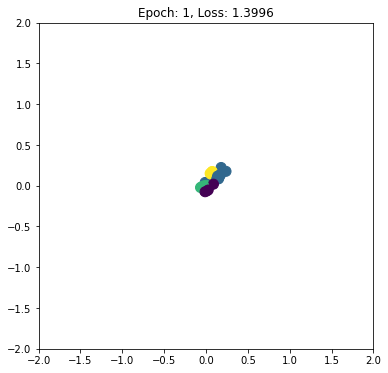

In [16]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
anim = animation.FuncAnimation(fig, animate, frames=len(epochs))
gif_writer = animation.PillowWriter(fps=20)
anim.save('Animation.gif', writer=gif_writer)